# [ Main QUEST ] 의료영상 U-Net 용종검출

# 목차

## 1. 데이터셋 구성

## 2. Encoder-Decoder 모델
- 2.1. 모델 설계
- 2.2. 모델 학습
- 2.3. 결과 분석

## 3. U-Net 모델
- 3.1. 모델 설계
- 3.2. 모델 학습
- 3.3. 결과 분석

## 4. pretrained model(VGG16)을 활용한 U-Net 모델
- 4.1. 모델 설계
- 4.2. 모델 학습
- 4.3. 결과 분석

## 5. 모델 성능 비교분석
- 5.1. Loss & Dice Loss 그래프 비교
- 5.2. meanIoU 비교
- 5.3. segmentation 결과 비교



In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.6.0


## 1. 데이터셋 구성
- augmentation이 반영된 tf.data.Dataset 구성

In [2]:
import os

# 디렉토리 경로 설정
medical_dir = os.path.join(os.getenv('HOME'), 'aiffel', 'medical', 'MQ')
data_dir = os.path.join(os.getenv('HOME'), 'data')

# 디렉토리 생성
if not os.path.exists(medical_dir):
    os.makedirs(medical_dir)

# 심볼릭 링크 생성
for filename in os.listdir(data_dir):
    src = os.path.join(data_dir, filename)
    dst = os.path.join(medical_dir, filename)
    if not os.path.exists(dst):
        os.symlink(src, dst)

# 경로 설정
DATASET_PATH = medical_dir
img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [3]:
# 데이터셋 분리
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [4]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


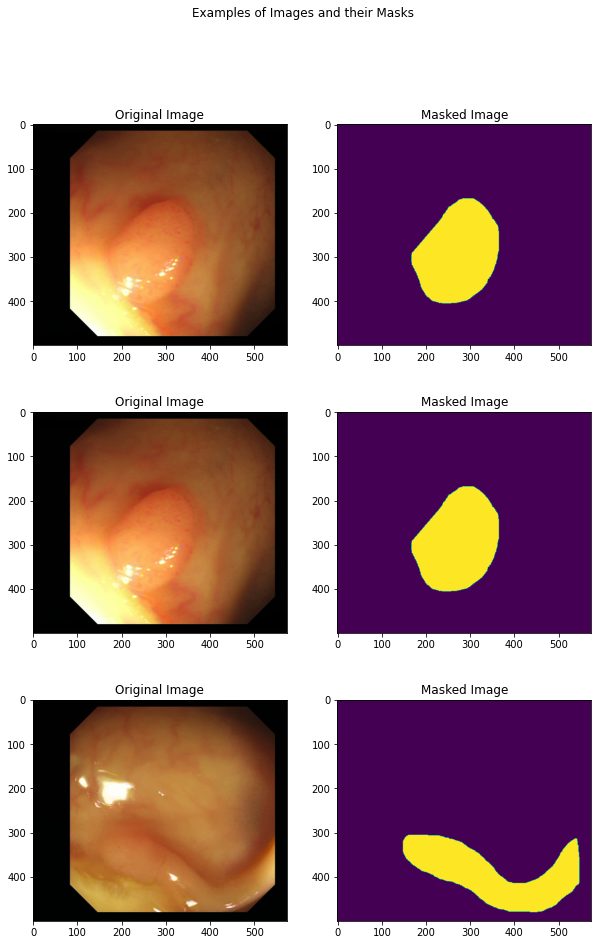

In [5]:
# 이미지 샘플 확인
display_num = 3

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

In [6]:
# Set hyperparameters
image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 10

In [7]:
# Processing each pathname
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]    # size 조절
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.                    # scale 조절
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

In [8]:
# Data augmentation - Shifting the image
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

In [9]:
# Data augmentation - Flipping the image randomly
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

In [10]:
# Data augmentation Assembling
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

In [11]:
# Set up train and test datasets
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [12]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

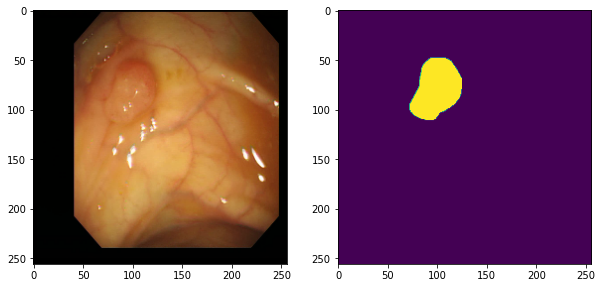

In [13]:
# train data 확인
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

## 2. Encoder-Decoder 모델

### 2.1. 모델 설계

In [14]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [15]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(8, 16, 16, 512)


In [16]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [17]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(8, 256, 256, 1)


In [18]:
# 모델 인스턴스 생성
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

### 2.2. 모델 학습

In [19]:
# 손실 함수 및 평가 지표 정의
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score
    
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss
    
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [20]:
# 옵티마이저 정의
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

In [21]:
print('select the Encoder-Decoder model')
model = ed_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

select the Encoder-Decoder model


In [22]:
# 모델 컴파일
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (8, 16, 16, 512)          4693056   
_________________________________________________________________
decoder (Sequential)         (8, 256, 256, 1)          2354913   
Total params: 7,047,969
Trainable params: 7,042,209
Non-trainable params: 5,760
_________________________________________________________________


In [24]:
# 체크포인트 저장 디렉토리
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [25]:
# learning rate decay 설정
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [26]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [27]:
# 모델 학습
ed_history = model.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 12s 215ms/step - loss: 1.1895 - dice_loss: 0.7731 - val_loss: 1.3691 - val_dice_loss: 0.7941
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 7s 205ms/step - loss: 0.9734 - dice_loss: 0.7105 - val_loss: 1.3391 - val_dice_loss: 0.7914
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 8s 206ms/step - loss: 0.9263 - dice_loss: 0.6910 - val_loss: 1.4247 - val_dice_loss: 0.7937
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 7s 208ms/step - loss: 0.8540 - dice_loss: 0.6419 - val_loss: 1.1109 - val_di

### 2.3. 결과 분석

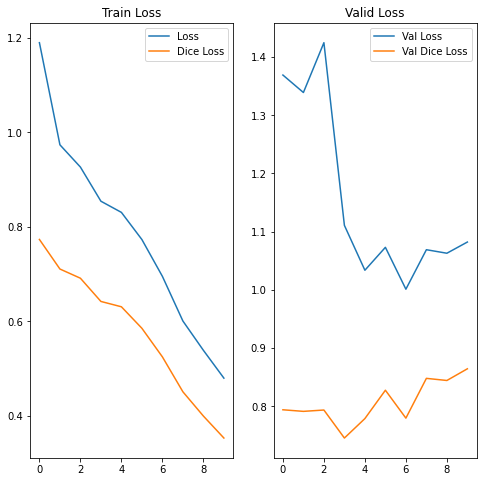

In [28]:
# loss 그래프 시각화
dice_loss = ed_history.history['dice_loss']
loss = ed_history.history['loss']
val_dice_loss = ed_history.history['val_dice_loss']
val_loss = ed_history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [29]:
# meanIoU 계산
checkpoint_dir = os.path.join(DATASET_PATH, 'ed_ckpt/ed_model')

model.load_weights(checkpoint_dir) # restoring the latest checkpoint in checkpoint_dir

def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [30]:
mean = []

for images, labels in test_dataset:
    predictions = ed_model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

ed_mean = np.array(mean)
ed_mean = np.mean(mean)
print("ed_mean_iou: {}".format(ed_mean))

ed_mean_iou: 0.648318011968074


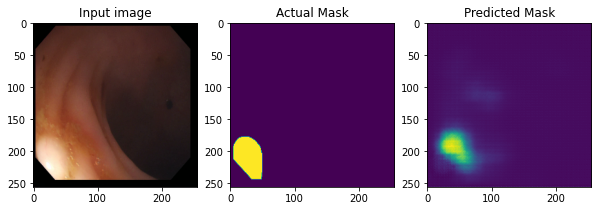

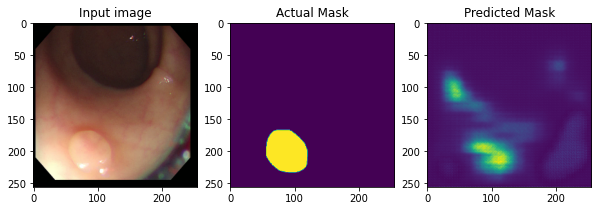

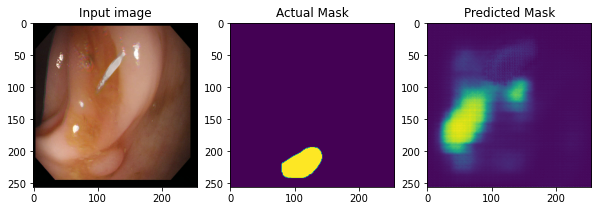

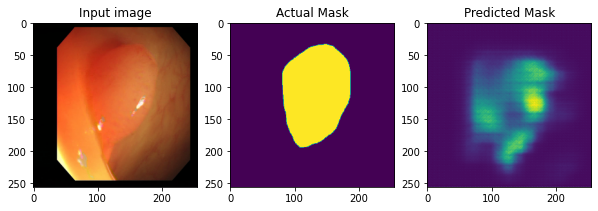

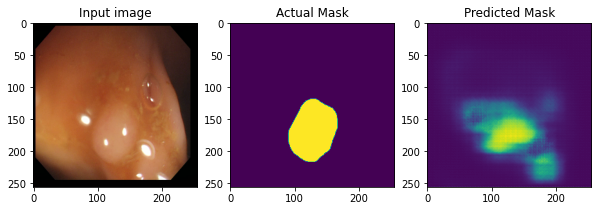

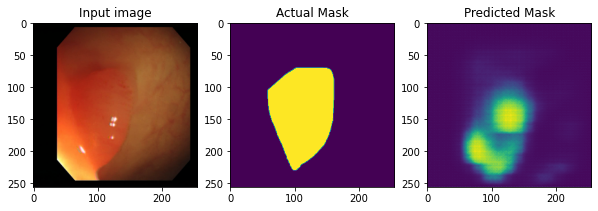

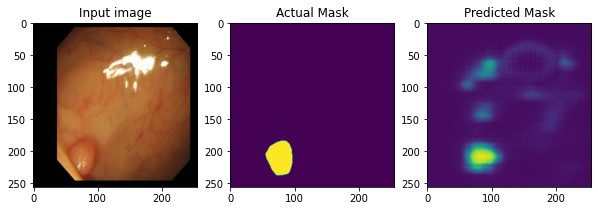

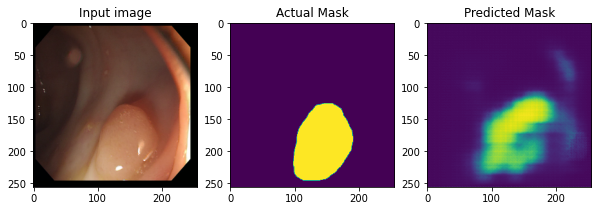

In [31]:
# Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()
            
# print image after training            
print_images()

## 3. U-Net 모델

### 3.1. 모델 설계

In [32]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [33]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [34]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

In [35]:
# 모델 인스턴스 생성
unet_model = UNet()

### 3.2. 모델 학습

In [36]:
# 손실 함수 및 평가 지표 정의
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score
    
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss
    
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [37]:
# 옵티마이저 정의
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

In [38]:
# 체크포인트 저장 디렉토리
print('select the U-Net model')
model = unet_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the U-Net model


In [39]:
# 모델 컴파일
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [40]:
model.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  18882048  
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  354278

In [41]:
# Callbacks
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [42]:
# learning rate decay 설정
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [43]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [44]:
# 모델 학습
unet_history = model.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 39s 911ms/step - loss: 1.0441 - dice_loss: 0.7308 - val_loss: 1017.5108 - val_dice_loss: 0.8955
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 28s 889ms/step - loss: 0.9177 - dice_loss: 0.7073 - val_loss: 2.9746 - val_dice_loss: 0.9556
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 28s 892ms/step - loss: 0.9045 - dice_loss: 0.7037 - val_loss: 1.0119 - val_dice_loss: 0.7278
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 28s 890ms/step - loss: 0.8898 - dice_loss: 0.6908 - val_loss: 1.2267 - 

### 3.3. 결과 분석

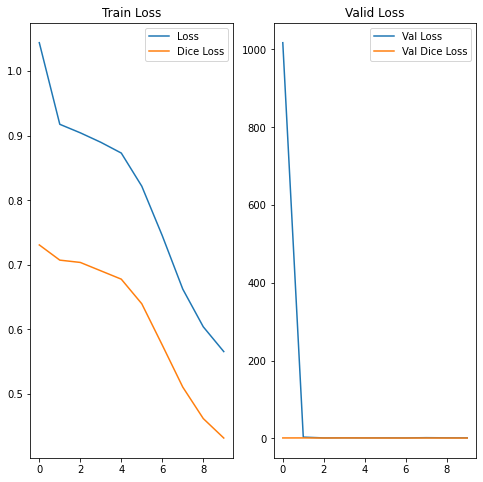

In [45]:
# loss 그래프 시각화
dice_loss = unet_history.history['dice_loss']
loss = unet_history.history['loss']
val_dice_loss = unet_history.history['val_dice_loss']
val_loss = unet_history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [46]:
# meanIoU 계산
checkpoint_dir = os.path.join(DATASET_PATH, 'unet_ckpt/unet_model')

model.load_weights(checkpoint_dir) # restoring the latest checkpoint in checkpoint_dir

def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [47]:
mean = []

for images, labels in test_dataset:
    predictions = unet_model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

unet_mean = np.array(mean)
unet_mean = np.mean(mean)
print("unet_mean_iou: {}".format(unet_mean))

unet_mean_iou: 0.941565198070861


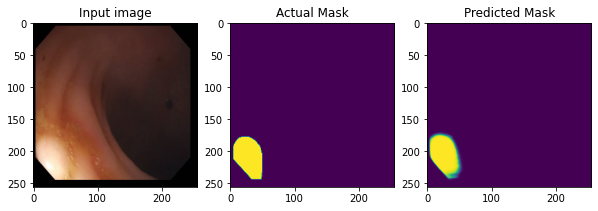

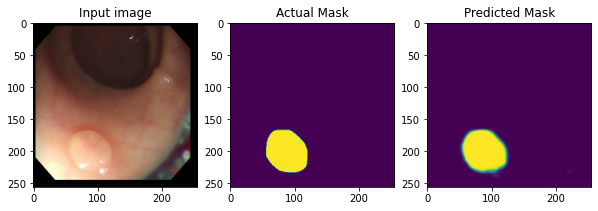

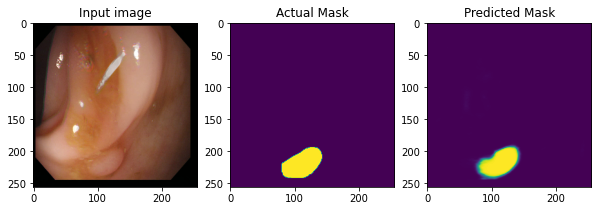

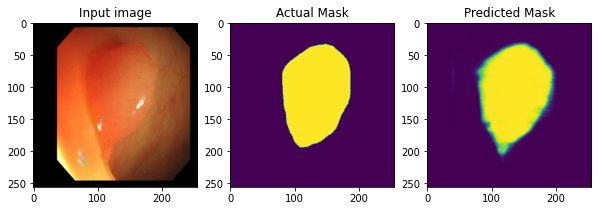

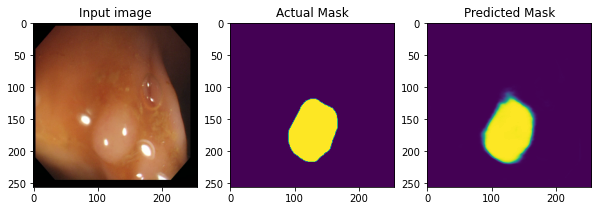

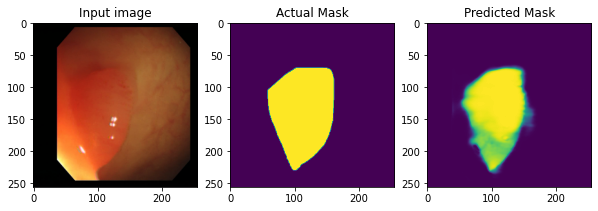

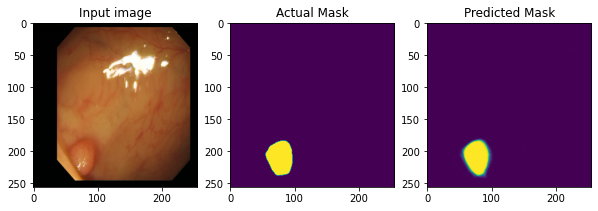

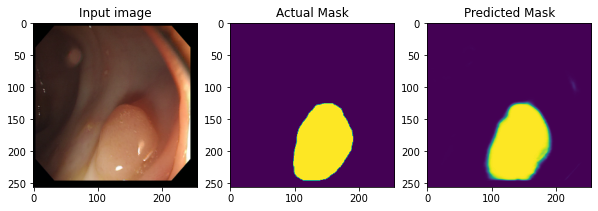

In [48]:
# Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()
            
# print image after training            
print_images()

## 4. pretrained model(VGG16)을 활용한 U-Net 모델

- U-Net 개선 모델 학습
- validation meanIoU가 기존 U-Net 대비 개선되었는지 확인

### 4.1. 모델 설계

In [49]:
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')

layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 32, 32, 256) dtype=float32 (created by layer 'block3_pool')>,


In [50]:
# VGG16을 Encoder로 활용하여 개선한 새로운 모델
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = tf.keras.models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs

### 4.2. 모델 학습

In [51]:
# 손실 함수 및 평가 지표 정의
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) +
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)
    return score

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred)) + \
           dice_loss(y_true, y_pred)
    return loss

In [52]:
# 모델 인스턴스 생성
vgg16_unet_model = Vgg16UNet()

In [53]:
# 옵티마이저 정의
optimizer = tf.keras.optimizers.Adam()

In [54]:
# 모델 컴파일
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])

In [55]:
# 체크포인트 저장 디렉토리
checkpoint_dir = os.path.join(DATASET_PATH, 'vgg16_unet_ckpt/vgg16_unet_model')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [56]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [57]:
# learning rate decay 설정
cos_decay = tf.keras.experimental.CosineDecay(initial_learning_rate=1e-3,
                                              decay_steps=max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [58]:
# 모델 학습
vgg_history = model.fit(train_dataset,
                    epochs=max_epochs,
                    steps_per_epoch=num_train_examples // batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples // batch_size,
                    callbacks=[cp_callback, lr_callback])

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 31s 906ms/step - loss: 0.1378 - dice_loss: 0.1014 - val_loss: 0.4655 - val_dice_loss: 0.2768

Epoch 00001: val_loss improved from inf to 0.46549, saving model to /aiffel/aiffel/medical/MQ/vgg16_unet_ckpt/vgg16_unet_model
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 28s 897ms/step - loss: 0.1283 - dice_loss: 0.0958 - val_loss: 0.6799 - val_dice_loss: 0.4338

Epoch 00002: val_loss did not improve from 0.46549
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 28s 891ms/step - loss: 0.1178 - dice_loss: 0.0873 - val_loss: 0.6937 - val_dice_loss: 0.4061

Epoch 00003: val_loss did not improve from 0.46549
Epoch 

### 4.3. 결과 분석

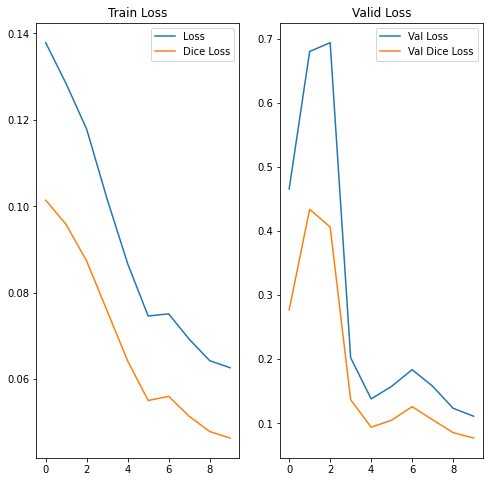

In [59]:
# loss 그래프 시각화
dice_loss = vgg_history.history['dice_loss']
loss = vgg_history.history['loss']
val_dice_loss = vgg_history.history['val_dice_loss']
val_loss = vgg_history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [60]:
# meanIoU 계산
checkpoint_dir = os.path.join(DATASET_PATH, 'vgg16_unet_ckpt/vgg16_unet_model')

model.load_weights(checkpoint_dir) # restoring the latest checkpoint in checkpoint_dir

def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [61]:
mean = []

for images, labels in test_dataset:
    predictions = vgg16_unet_model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

vgg_mean = np.array(mean)
vgg_mean = np.mean(mean)
print("Vgg16_Unet_mean_iou: {}".format(vgg_mean))

vgg_mean_iou: 0.42968082774694694


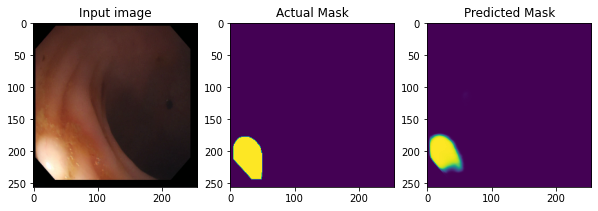

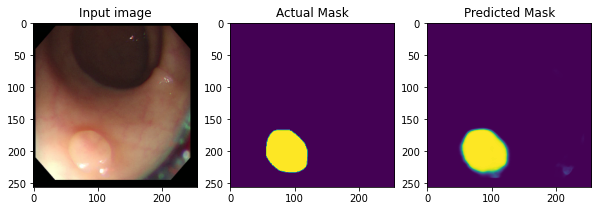

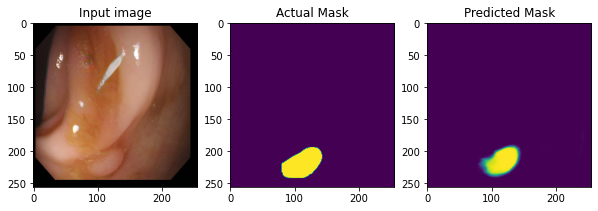

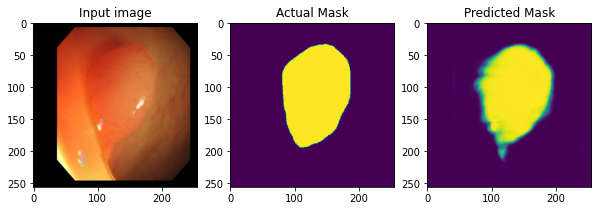

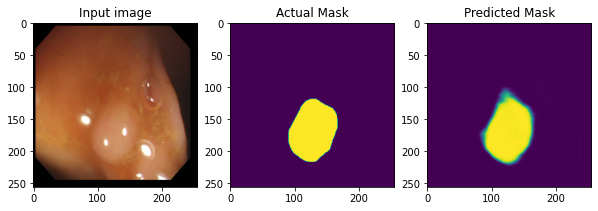

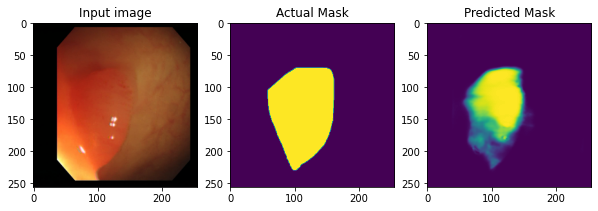

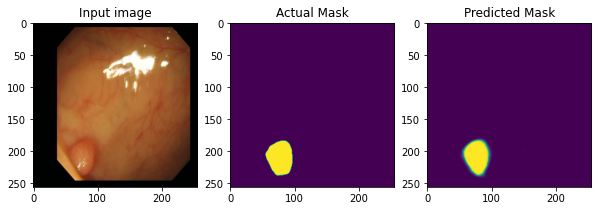

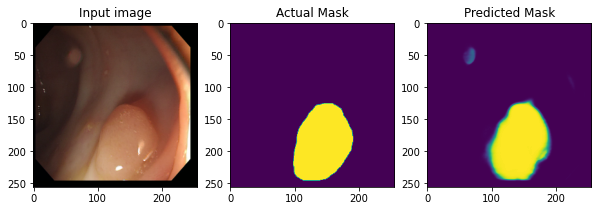

In [62]:
# Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()
            
# print image after training            
print_images()

## 5. 모델 성능 비교분석

### 5.1. Loss & Dice Loss 그래프 비교

In [63]:
def plot_all_model_results(ed_history, unet_history, vgg_history):
    # Epoch 범위
    epochs_range = range(len(ed_history.history['loss']))

    # 각 모델의 loss 및 dice loss 가져오기
    ed_loss = ed_history.history['loss']
    ed_val_loss = ed_history.history['val_loss']
    ed_dice = ed_history.history['dice_loss']
    ed_val_dice = ed_history.history['val_dice_loss']

    unet_loss = unet_history.history['loss']
    unet_val_loss = unet_history.history['val_loss']
    unet_dice = unet_history.history['dice_loss']
    unet_val_dice = unet_history.history['val_dice_loss']

    vgg_loss = vgg_history.history['loss']
    vgg_val_loss = vgg_history.history['val_loss']
    vgg_dice = vgg_history.history['dice_loss']
    vgg_val_dice = vgg_history.history['val_dice_loss']

    # Loss 비교 그래프
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, ed_loss, label='ED Loss')
    plt.plot(epochs_range, unet_loss, label='U-Net Loss')
    plt.plot(epochs_range, vgg_loss, label='VGG16 U-Net Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, ed_val_loss, label='ED Val Loss')
    plt.plot(epochs_range, unet_val_loss, label='U-Net Val Loss')
    plt.plot(epochs_range, vgg_val_loss, label='VGG16 U-Net Val Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Val Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Dice Loss 비교 그래프
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, ed_dice, label='ED Dice Loss')
    plt.plot(epochs_range, unet_dice, label='U-Net Dice Loss')
    plt.plot(epochs_range, vgg_dice, label='VGG16 U-Net Dice Loss')
    plt.title('Training Dice Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, ed_val_dice, label='ED Val Dice Loss')
    plt.plot(epochs_range, unet_val_dice, label='U-Net Val Dice Loss')
    plt.plot(epochs_range, vgg_val_dice, label='VGG16 U-Net Val Dice Loss')
    plt.title('Validation Dice Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Val Dice Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

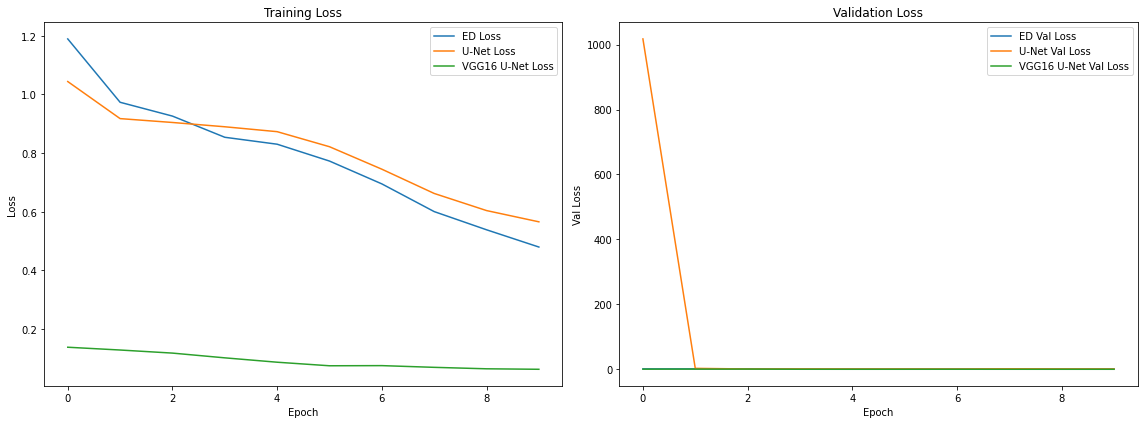

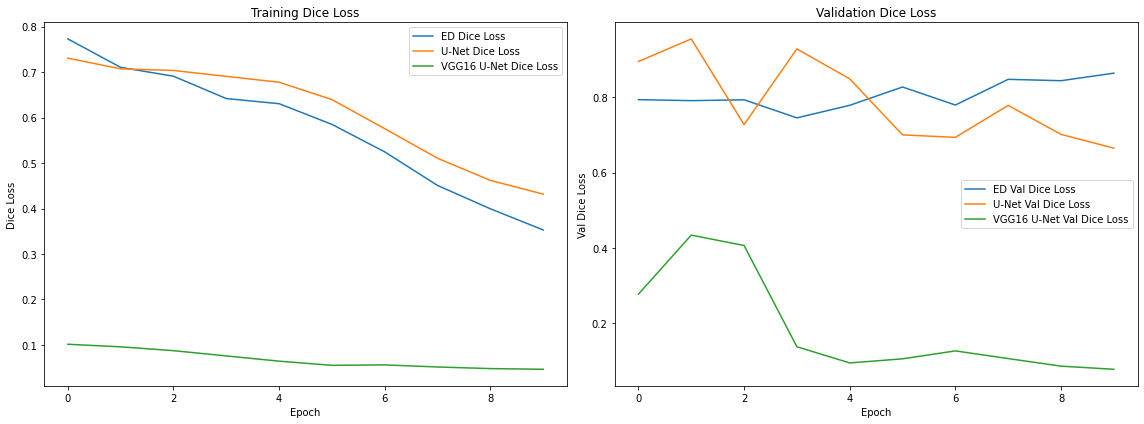

In [64]:
plot_all_model_results(ed_history, unet_history, vgg_history)

### 5.2. meanIoU 비교

In [70]:
print("validation meanIoU Scores")
print("===========================")
print(f"Encoder-Decoder: {ed_mean:.4f}")
print(f"U-Net          : {unet_mean:.4f}")
print(f"VGG16 U-Net    : {vgg_mean:.4f}")

validation meanIoU Scores
Encoder-Decoder: 0.6483
U-Net          : 0.9416
VGG16 U-Net    : 0.4297


In [72]:
import pandas as pd

# 모델 이름과 mean IoU 값 리스트
model_names = ['Encoder-Decoder', 'U-Net', 'VGG16 U-Net']
mean_ious = [ed_mean, unet_mean, vgg_mean]

# 데이터프레임 생성
iou_df = pd.DataFrame({
    'Model': model_names,
    'validation meanIoU': mean_ious
})

# 표 출력
from IPython.display import display
display(iou_df)

,Model,validation meanIoU
0,Encoder-Decoder,0.648318
1,U-Net,0.941565
2,VGG16 U-Net,0.429681


### 5.3. segmentation 결과 비교
1. Input : 원본 입력 이미지
2. Ground Truth : 직접 만든 정답 마스크(Label mask)
3. ED (Encoder-Decoder) : Encoder-Decoder 모델의 예측 결과
4. U-Net : U-Net 모델의 예측 결과
5. VGG16 U-Net : VGG16 모델을 Encoder로 사용한 U-Net 모델의 예측 결과

In [68]:
def print_compare_predictions(ed_model, unet_model, vgg_model, test_dataset, batch_size=1):
    for test_images, test_labels in test_dataset.take(1):
        ed_preds = ed_model(test_images, training=False)
        unet_preds = unet_model(test_images, training=False)
        vgg_preds = vgg_model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(20, 5))
            
            # 원본 이미지
            plt.subplot(1, 5, 1)
            plt.imshow(test_images[i])
            plt.title("Input Image")
            plt.axis('off')
            
            # 실제 마스크
            plt.subplot(1, 5, 2)
            plt.imshow(test_labels[i, :, :, 0], cmap='gray')
            plt.title("Ground Truth")
            plt.axis('off')

            # Encoder-Decoder 결과
            plt.subplot(1, 5, 3)
            plt.imshow(ed_preds[i, :, :, 0], cmap='gray')
            plt.title("ED Predicted Mask")
            plt.axis('off')

            # U-Net 결과
            plt.subplot(1, 5, 4)
            plt.imshow(unet_preds[i, :, :, 0], cmap='gray')
            plt.title("U-Net Predicted Mask")
            plt.axis('off')

            # VGG16 기반 U-Net 결과
            plt.subplot(1, 5, 5)
            plt.imshow(vgg_preds[i, :, :, 0], cmap='gray')
            plt.title("VGG16 U-Net Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

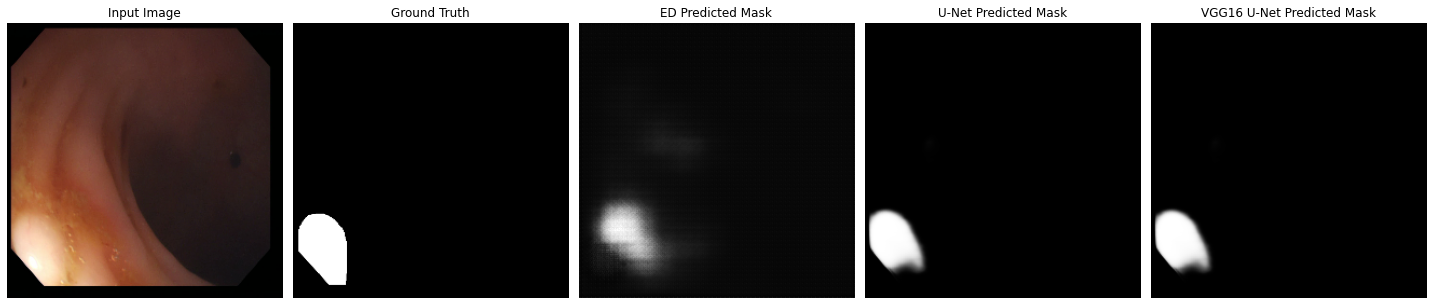

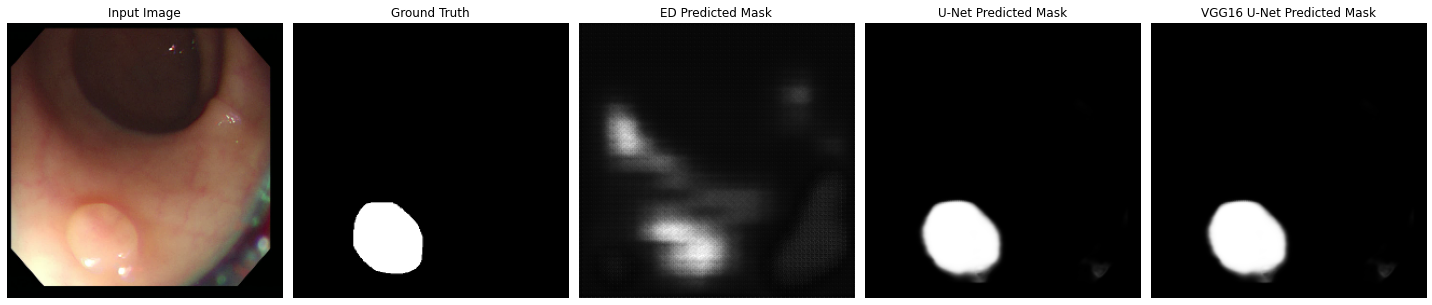

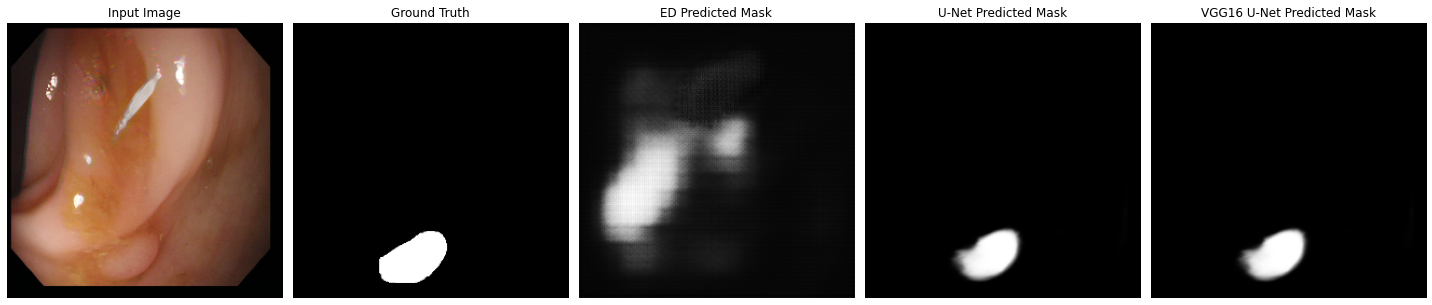

In [69]:
print_compare_predictions(ed_model, unet_model, model, test_dataset, batch_size=3)

### ✅ 비교 결과 :


**1. Encoder-Decoder 모델**
- Train Loss/Dice Loss: 점진적으로 감소
- Val Loss/Dice Loss: 점점 안정되나, 성능은 중간 수준
- mean IoU: 0.6483

***> 성능은 U-Net에 비해 떨어짐***\
***> 마스크의 품질도 경계가 흐릿하고 다소 부정확한 양상임***

---

**2. U-Net 모델**
- Train & Val Loss/Dice Loss: 안정적으로 감소
- Val Dice Loss 변동 있음에도 평균 성능이 우수
- mean IoU: 0.9416

***> 일관된 분할 품질로, 매우 높은 성능을 보임***\
***> 시각적으로도 정확한 마스크가 형성됨***

---

**3. VGG16 U-Net 모델**
- Train Loss/Dice Loss: 매우 낮음 → 과도하게 학습됨
- Val Loss/Dice Loss: 거의 0에 가까운 값, 하지만 실제 성능은 낮음
- mean IoU: 0.4297

***> 과적합 (Overfitting) 가능성 매우 높음. 훈련 데이터에 너무 잘 맞았고, 검증 데이터에서는 성능이 뚝 떨어짐***\
***> 시각화에서도 대상이 없는 부분까지 과도하게 예측하는 경향이 있음***

---
---

### 🔍 원인 분석 : 왜 "VGG16 기반 U-Net"의 성능이 "기본 U-Net"보다 낮게 나오는가?

1. Feature 불일치
- **VGG16은 ImageNet(classification)용으로 학습된 모델**임. 즉, 전체 이미지를 한 덩어리로 보고 분류하는 데 특화됨
- 하지만 세그멘테이션은 픽셀 단위의 예측을 요구함
- 따라서 **분할에 필요한 미세한 위치 정보나 경계 정보가 손실**될 수 있음
---
2. 과적합 문제
- VGG16은 파라미터 수가 많아 복잡하고 무겁다 보니 **작은 데이터셋에서 쉽게 과적합**됨
- weights='imagenet'으로 가져온 pretrained weight가 의미 없는 세그멘테이션 task에 그대로 적용됨
---
3. Decoder가 충분히 강력하지 않음
- VGG16의 encoder는 deep하지만, 그만큼 **decoder도 그 깊이에 맞는 복원 능력이 있어야 함**
- U-Net에서 encoder만 바꾸면 되는 게 아니라, decoder도 같이 튜닝해줘야 함
---
4. Feature map 추출 위치의 문제
- **feature map이 너무 얕거나 깊을 수 있음**
- 실제 이미지에 잘 맞는 feature 수준을 선택하지 않으면 skip 연결 자체가 무의미해질 수 있음
---
5. Normalization mismatch
- VGG16은 tf.keras.applications.vgg16.preprocess_input()으로 전처리된 데이터를 가정하고 있음
- 그런데 위 모델에서는 [0, 1] scaling만 적용하고 있음

## (추가) 😎 DeepLabV3+ in TensorFlow
- Atrous Convolution (dilated conv): 더 넓은 수용영역으로 global context 반영
- ASPP (Atrous Spatial Pyramid Pooling): 다양한 크기의 필터로 다중 스케일 feature 추출
- (v3+) Encoder-Decoder 구조 추가로 경계 복원 강화

In [73]:
# 필요 라이브러리 설치
!pip install segmentation-models

In [75]:
import os
import tensorflow as tf
import segmentation_models as sm
import pickle
import matplotlib.pyplot as plt

In [76]:
# 경로 설정
DATASET_PATH = os.path.expanduser('~/aiffel/medical/MQ')
SAVE_DIR = os.path.join(DATASET_PATH, 'deeplabv3plus_ckpt')
MODEL_PATH = os.path.join(SAVE_DIR, 'deeplabv3plus_model')
HISTORY_PATH = os.path.join(SAVE_DIR, 'deeplabv3plus_history.pkl')

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [77]:
# 모델 준비
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

image_size = 256
input_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 10

In [78]:
# 데이터 전처리
def preprocess(img, label_img):
    img = preprocess_input(img)
    return img, label_img

train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

In [79]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss=sm.losses.bce_dice_loss,
              metrics=[sm.metrics.iou_score])

In [80]:
# 모델 학습
deeplabv3_history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=max_epochs,
                    steps_per_epoch=num_train_examples // batch_size,
                    validation_steps=num_test_examples // batch_size)

Epoch 1/10
30/30 [==============================] - 31s 883ms/step - loss: 0.1813 - iou_score: 0.7595 - val_loss: 0.3833 - val_iou_score: 0.5872
Epoch 2/10
30/30 [==============================] - 28s 897ms/step - loss: 0.1754 - iou_score: 0.7679 - val_loss: 0.3760 - val_iou_score: 0.6168
Epoch 3/10
30/30 [==============================] - 28s 896ms/step - loss: 0.1470 - iou_score: 0.7990 - val_loss: 0.8886 - val_iou_score: 0.2449
Epoch 4/10
30/30 [==============================] - 28s 881ms/step - loss: 0.1376 - iou_score: 0.8114 - val_loss: 0.2946 - val_iou_score: 0.6763
Epoch 5/10
30/30 [==============================] - 28s 888ms/step - loss: 0.1353 - iou_score: 0.8154 - val_loss: 0.2753 - val_iou_score: 0.6942
Epoch 6/10
30/30 [==============================] - 28s 892ms/step - loss: 0.1558 - iou_score: 0.7942 - val_loss: 0.4782 - val_iou_score: 0.5484
Epoch 7/10
30/30 [==============================] - 28s 889ms/step - loss: 0.1681 - iou_score: 0.7761 - val_loss: 0.5121 - val_iou

In [81]:
# 모델 저장
model.save(MODEL_PATH)

INFO:tensorflow:Assets written to: /aiffel/aiffel/medical/MQ/deeplabv3plus_ckpt/deeplabv3plus_model/assets


In [82]:
# 학습 이력 저장
with open(HISTORY_PATH, 'wb') as f:
    pickle.dump(deeplabv3_history.history, f)

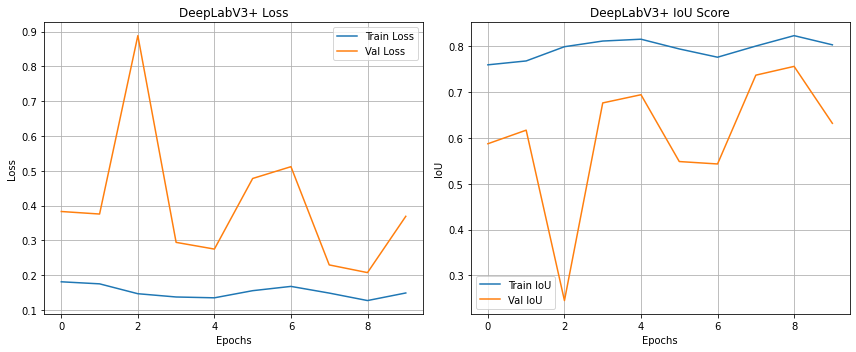

In [97]:
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(deeplabv3_history.history['loss'], label='Train Loss')
plt.plot(deeplabv3_history.history['val_loss'], label='Val Loss')
plt.title('DeepLabV3+ Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# IoU Score 그래프
plt.subplot(1, 2, 2)
plt.plot(deeplabv3_history.history['iou_score'], label='Train IoU')
plt.plot(deeplabv3_history.history['val_iou_score'], label='Val IoU')
plt.title('DeepLabV3+ IoU Score')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [94]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Binarize prediction
    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()
    
    # Confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)
    
    # Intersection and union
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    
    iou = intersection / np.maximum(union, 1e-10)
    return np.mean(iou)

In [95]:
mean = []

for images, labels in test_dataset:
    preds = model(images, training=False)
    m = mean_iou(labels, preds)
    mean.append(m)

deeplab_mean_iou = np.mean(mean)
print("DeepLabV3+ Validation Mean IoU: {:.4f}".format(deeplab_mean_iou))

DeepLabV3+ Validation Mean IoU: 0.7987


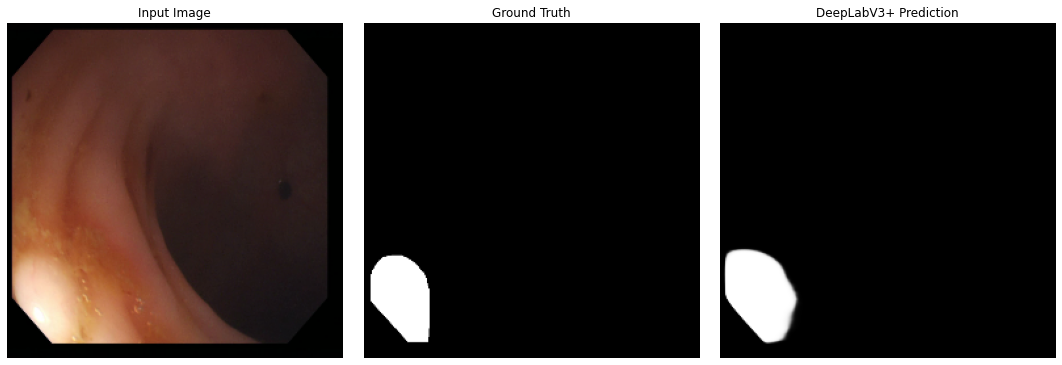

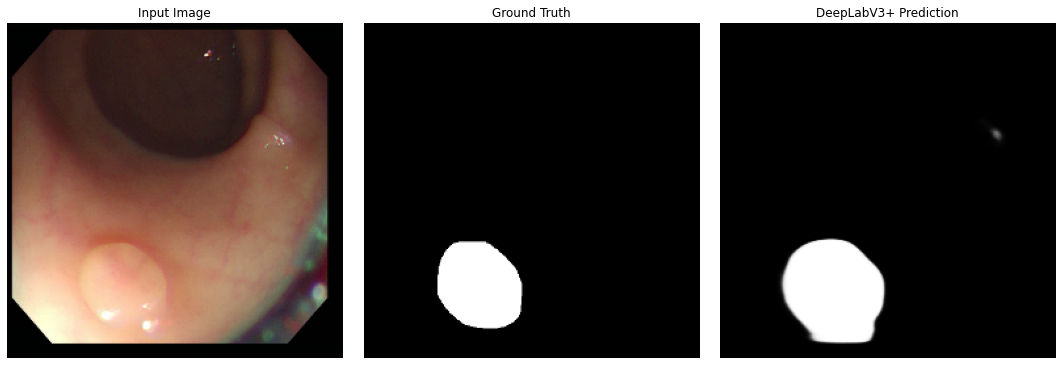

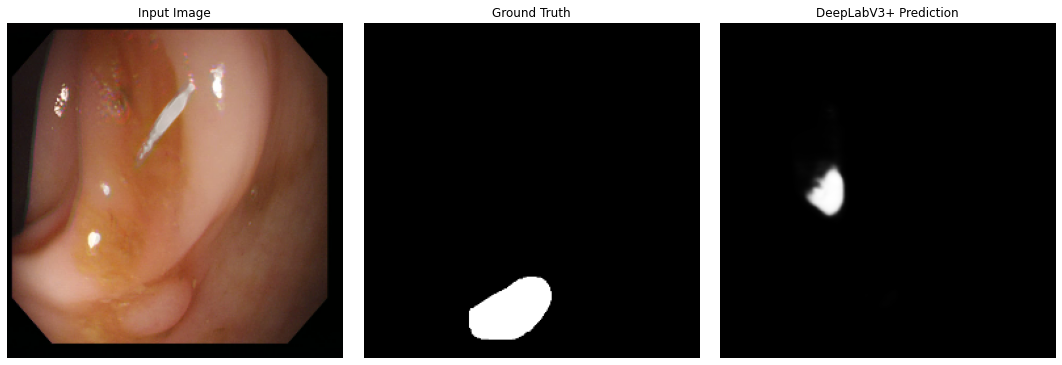

In [96]:
# 시각화
def print_deeplab_predictions(deeplab_model, test_dataset, batch_size=3):
    for test_images, test_labels in test_dataset.take(1):
        test_images_np = test_images.numpy()
        test_labels_np = test_labels.numpy()

        preds = deeplab_model(test_images, training=False).numpy()

        for i in range(min(batch_size, test_images_np.shape[0])):
            plt.figure(figsize=(15, 5))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(test_images_np[i])
            plt.title("Input Image")
            plt.axis('off')

            # Ground Truth
            plt.subplot(1, 3, 2)
            plt.imshow(test_labels_np[i, :, :, 0], cmap='gray')
            plt.title("Ground Truth")
            plt.axis('off')

            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.imshow(preds[i, :, :, 0], cmap='gray')
            plt.title("DeepLabV3+ Prediction")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

print_deeplab_predictions(model, test_dataset, batch_size=3)